# <font color=green>**Participez à la conception d'une voiture autonome**
## Notebook 3 - U-Net : Test d'augmentation des données et optimization des paramètres 

In [1]:
#!pip install -q -U tensorflow-addons

In [2]:
#!pip install segmentation-models

In [ ]:
#import librairies
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import os.path
import scipy.misc
import os
from glob import glob
from sklearn.utils import shuffle
import random
import time
import shutil
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model, Sequential
%env SM_FRAMEWORK=tf.keras
from segmentation_models.metrics import IOUScore,FScore
from warnings import warn
from functions import *


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
# drive connection
from google.colab import drive 
drive.mount('/content/drive')#,force_remount=True)

Mounted at /content/drive


In [ ]:
# Set variables
#patch for acces to train, valid and test data
DATA_PATH = "../data" 
IMAGE_SIZE = 128
EPOCHS = 3
metrics = ['categorical_accuracy',FScore(),IOUScore()]
metrics_to_display = ["loss","categorical_accuracy","f1-score","iou_score"]
optimizer='adam'
tab_compare = pd.DataFrame(columns=['Model','Data augmentation','Categorical accuracy','Loss','Dice Coefficient','Intersection-Over-Union','Build training time','Used memory','Predict data time'])

In [ ]:
# Modification du class CustomDataGenerator pour le test differents data augmentation
class CustomDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, images_and_labels, label_values, colors_replacements, n_classes = 8,batch_size=10, target_size=(128,256), shuffle=True,data_augmentation=False ):
        'Initialization'
        self.target_size = target_size
        self.images_and_labels = images_and_labels
        self.label_values = label_values
        self.colors_replacements = colors_replacements
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_augmentation = data_augmentation
        self.on_epoch_end()
      
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images_and_labels) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images_and_labels[i][0] ,color_mode="rgb",target_size=self.target_size)
            img = img_to_array(img)/255.
            label = load_img(self.images_and_labels[i][1],color_mode="rgb",target_size=self.target_size)
            label = img_to_array(label)
            if self.data_augmentation:
              #img, label = self.__data_aug_crop(img, label)
              #img, label = self.__data_aug_flip(img, label)
              #img, label = self.__data_aug_rotate(img, label)
              #img, label = self.__data_aug_BrightnessContrast(img, label)
              img, label = self.__data_aug(img, label)
              #if (tf.is_tensor(label)):
                  #label =label.numpy() 
            #img = img_to_array(img)/255.
            #label = img_to_array(label)
            label = change_color(label,self.colors_replacements)
            #label = np.array([label]) 
            #batch_labels.append(np.float32(one_hot_it(label, self.label_values)))
            
            label = transform_label(label,self.label_values)
            label = to_categorical(label,self.n_classes)
            #label = tf.convert_to_tensor(label, np.float32)
            batch_imgs.append(img)
            batch_labels.append(label)
        return np.array(batch_imgs),np.array(batch_labels)

    def __data_aug(self,input_image, input_mask):
        # random data augmentation
        input_mask = input_mask/255
        transform = A.Compose([A.HorizontalFlip(),A.RandomBrightnessContrast()])
        transformed = transform(image=input_image, mask=input_mask)
        input_image = transformed['image']
        input_mask = transformed['mask']
        input_mask = input_mask*255
        return input_image, input_mask

 

    def __data_aug_flip(self,input_image, input_mask):
        # random data 
        input_mask = input_mask/255
        aug = A.HorizontalFlip(p=0.5)
        augmented = aug(image=input_image, mask=input_mask)
        input_image = augmented['image']
        input_mask = augmented['mask']
        input_mask = input_mask*255
        return input_image, input_mask

    def __data_aug_rotate(self,input_image, input_mask):
        # random data 
        input_mask = input_mask/255
        aug = A.Rotate((-30,30), p=0.5)
        augmented = aug(image=input_image, mask=input_mask)
        input_image = augmented['image']
        input_mask = augmented['mask']
        input_mask = input_mask*255
        return input_image, input_mask

    def __data_aug_crop(self,input_image, input_mask):
        # random data 
       input_mask= img_to_array(input_mask)/255.
        # Random crop
       aug = A.RandomSizedCrop((80,100),self.target_size[0],self.target_size[1],w2h_ratio=(2), p=0.5)
       augmented = aug(image=input_image, mask=input_mask)
       input_image = augmented['image']
       input_mask = augmented['mask']
       input_mask = input_mask*255
       return input_image, input_mask

    def __data_aug_BrightnessContrast(self,input_image, input_mask):
        # random data 
        input_mask = input_mask/255
        aug = A.RandomBrightnessContrast()
        augmented = aug(image=input_image, mask=input_mask)
        input_image = augmented['image']
        input_mask = augmented['mask']
        input_mask = input_mask*255
        return input_image, input_mask

 

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images_and_labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


In [ ]:
# Check whether GPU is enabled
if not tf.test.gpu_device_name():
    warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


Recuperation des labels

In [ ]:
# get labels
labels = get_label_info()
label_values, colors_replacements = get_labels_mapping(labels)

Recuperation des données

In [ ]:
#train data
train_batch = glob(os.path.join(DATA_PATH+'/train/images/', '*.png'))
train_label_batch = glob(os.path.join(DATA_PATH +'/train/masks/', '*.png'))
train_batch.sort()
train_label_batch.sort()
#validation data
val_batch = glob(os.path.join(DATA_PATH+'/val/images/', '*.png'))
val_label_batch = glob(os.path.join(DATA_PATH +'/val/masks/', '*.png'))
val_batch.sort()
val_label_batch.sort()
#test data
test_batch = glob(os.path.join(DATA_PATH+'/test/images/', '*.png'))
test_label_batch = glob(os.path.join(DATA_PATH +'/test/masks/', '*.png'))
test_batch.sort()
test_label_batch.sort()

In [ ]:
# pair of path data for image, mask
# pair of path data for image, mask
train_set = get_tuple_image_mask(train_batch,train_label_batch)[:100]
valid_set = get_tuple_image_mask(val_batch,val_label_batch)[:30]
test_set = get_tuple_image_mask(test_batch,test_label_batch)[:10]
print(train_batch[0])
print(train_label_batch[0])
print(train_batch[0])
print(train_label_batch[0])
print(val_batch[0])
print(val_label_batch[0])


drive/MyDrive/OpenclassroomsP8/data/train/images/aachen_000000_000019.png
drive/MyDrive/OpenclassroomsP8/data/train/masks/aachen_000000_000019.png
drive/MyDrive/OpenclassroomsP8/data/val/images/frankfurt_000000_000294.png
drive/MyDrive/OpenclassroomsP8/data/val/masks/frankfurt_000000_000294.png


In [ ]:
print(val_batch[0])
print(val_label_batch[0])

drive/MyDrive/OpenclassroomsP8/data/val/images/frankfurt_000000_000294.png
drive/MyDrive/OpenclassroomsP8/data/val/masks/frankfurt_000000_000294.png


In [ ]:
train_set[10]

('drive/MyDrive/OpenclassroomsP8/data/train/images/aachen_000023_000019.png',
 'drive/MyDrive/OpenclassroomsP8/data/train/masks/aachen_000023_000019.png')

## Data augmentation +  U-Net

---



---



In [ ]:
# create Unet model
model_Unet = Unet(IMAGE_SIZE,2*IMAGE_SIZE, 64)
#model_Unet.summary()

In [ ]:

model_Unet.compile(optimizer=optimizer, loss='categorical_crossentropy' ,metrics=metrics)

In [ ]:
# cette partie a été lancée plusieurs fois avec differentes techniques de data generateur
train_generator_unet = CustomDataGenerator(images_and_labels=train_set,batch_size = 6, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=True)
val_generator_unet = CustomDataGenerator(images_and_labels=valid_set,batch_size = 6, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps_unet = train_generator_unet.__len__()
val_steps_unet = val_generator_unet.__len__()
train_steps_unet, val_steps_unet

(83, 41)

In [ ]:
start = time.time()
results_Unet = model_Unet.fit(train_generator_unet ,batch_size = BATCH_SIZE, steps_per_epoch=train_steps_unet ,epochs=6,validation_data=val_generator_unet,validation_steps=val_steps_unet)
end = time.time()
builf_Unet_time =timer(start,end)

Epoch 1/6
83/83 [==============================] - 152s 2s/step - loss: 0.4883 - categorical_accuracy: 0.8396 - f1-score: 0.5938 - iou_score: 0.4753 - val_loss: 0.7248 - val_categorical_accuracy: 0.8018 - val_f1-score: 0.5784 - val_iou_score: 0.4572
Epoch 2/6
83/83 [==============================] - 147s 2s/step - loss: 0.4290 - categorical_accuracy: 0.8618 - f1-score: 0.6130 - iou_score: 0.4986 - val_loss: 0.6557 - val_categorical_accuracy: 0.8007 - val_f1-score: 0.5774 - val_iou_score: 0.4562
Epoch 3/6
83/83 [==============================] - 146s 2s/step - loss: 0.4427 - categorical_accuracy: 0.8547 - f1-score: 0.6169 - iou_score: 0.4969 - val_loss: 0.5686 - val_categorical_accuracy: 0.8254 - val_f1-score: 0.6039 - val_iou_score: 0.4815
Epoch 4/6
83/83 [==============================] - 145s 2s/step - loss: 0.4220 - categorical_accuracy: 0.8625 - f1-score: 0.6236 - iou_score: 0.5063 - val_loss: 0.6005 - val_categorical_accuracy: 0.7960 - val_f1-score: 0.5867 - val_iou_score: 0.4638


MODEL:  U-Net
Build training model time:  00:14:42.16
Predict test data time:  00:00:43.62
41/41 [==============================] - 45s 1s/step - loss: 0.6155 - categorical_accuracy: 0.8296 - f1-score: 0.5969 - iou_score: 0.4867
Categorical accuracy: 82.9636
Loss : 0.6155
Dice Coefficient : 59.6864
Intersection-Over-Union : 48.6682


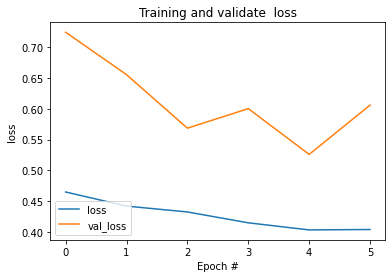

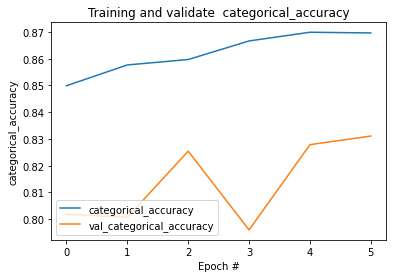

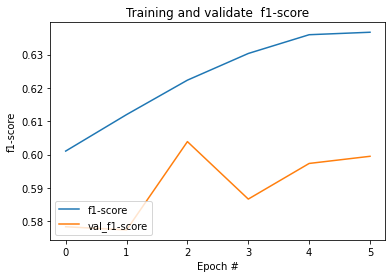

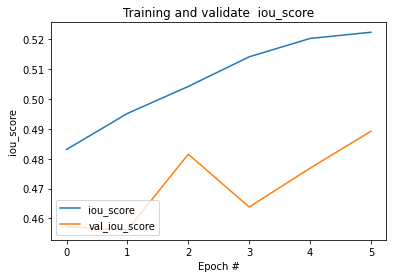

In [ ]:
#tab_compare=tab_compare.append(get_scoring(model_Unet,'U-Net', val_generator_unet,builf_Unet_time),ignore_index=True)
display_loss_and_metrics(6,results_Unet.history,"iou_score")

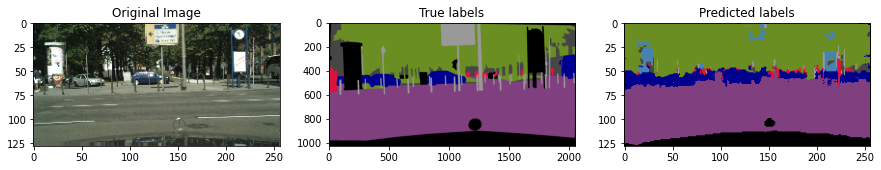

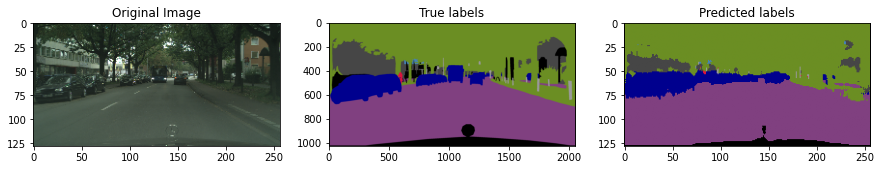

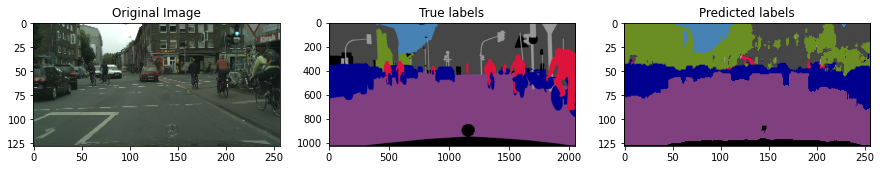

In [ ]:
display_random_test_images(model_Unet,valid_set,colors_replacements,nb_images=3)

In [ ]:
df_sorted1.head(6)

,Model,Data augmentation,Categorical accuracy,Loss,Dice Coefficient,Intersection-Over-Union,Build training time,Used memory,Predict data time
0,U-Net,Random crop,80.467063,0.567984,54.512894,41.998458,00:18:38.90,0,00:00:41.14
1,U-Net,Rotation,81.326109,0.605095,56.319416,44.245347,00:29:16.55,0,00:00:42.71
2,U-Net,No,83.482659,0.515926,57.460308,45.169681,00:19:22.66,0,00:00:44.48
3,U-Net,Brightness Contrast,81.936610,0.583728,58.283561,45.969439,00:18:24.36,0,00:00:40.97
4,U-Net,Flip left right,83.307791,0.592340,60.249293,48.261976,00:31:47.44,0,00:00:44.02
5,U-Net,Flip left right and Brightness Contrast,82.963610,0.615495,59.686375,48.668182,00:14:42.16,0,00:00:43.62


Flip left right and Brightness Contrast ont été ajouté dans le modèle final

# Optimisation Loss fonction+ U-Net

In [ ]:
tuning_res = pd.DataFrame(columns=['Model','Data augmentation','Loss type','Loss','Dice Coefficient','Intersection-Over-Union'])

In [ ]:
#segmentation_models.losses.CategoricalFocalLoss()
#segmentation_models.losses.CategoricalCELoss
#segmentation_models.losses.DiceLoss
#segmentation_models.losses.JaccardLoss(

In [ ]:
from segmentation_models.losses import CategoricalFocalLoss,CategoricalCELoss,DiceLoss,JaccardLoss

In [ ]:
loss_list = [CategoricalCELoss(),CategoricalFocalLoss(),DiceLoss(),JaccardLoss()]


In [ ]:
IMAGE_SIZE = 128
batch_size = 100
num_epochs = 6

In [ ]:
train_generator = CustomDataGenerator(images_and_labels=train_set,batch_size = 6, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=True)
val_generator = CustomDataGenerator(images_and_labels=valid_set,batch_size = 6, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()
train_steps, val_steps

(83, 41)

In [ ]:
# test differents loss

results =[]

for loss in loss_list:
    loss_name = ''
    if isfunction(loss):
        loss_name = loss.__name__
    else:
        loss_name = loss.name

    start = time.time()
    model_Final = Unet(IMAGE_SIZE,2*IMAGE_SIZE, 64)
    model_Final.compile(optimizer='adam', loss=loss ,metrics=metrics)
    history_final = model_Final.fit(train_generator , steps_per_epoch=train_steps ,batch_size=batch_size,epochs=num_epochs,validation_data=val_generator,validation_steps=val_steps)
    end = time.time()
    scores = model_Final.evaluate(val_generator, verbose=1,return_dict=True);
    train_model_final_time =timer(start,end)
    print('- -'*30)
    ligne_resultat = {'Model':'U-Net',
                            'Data augmentation':'Yes',
                            'Categorical accuracy':scores.get('categorical_accuracy')*100,
                            'Loss type':loss_name ,
                            'Loss':scores.get('loss'),
                            'Dice Coefficient':scores.get('f1-score')*100,
                            'Intersection-Over-Union':scores.get('iou_score')*100
                          
                            
                          }
    tuning_res= tuning_res.append(ligne_resultat,ignore_index=True)
    print('- -'*30)
    print(ligne_resultat)
    print('- -'*30)

Epoch 1/6
83/83 [==============================] - 144s 2s/step - loss: 0.1455 - categorical_accuracy: 0.6201 - f1-score: 0.3238 - iou_score: 0.2235 - val_loss: 0.4222 - val_categorical_accuracy: 0.5625 - val_f1-score: 0.2098 - val_iou_score: 0.1527
Epoch 2/6
83/83 [==============================] - 139s 2s/step - loss: 0.0786 - categorical_accuracy: 0.7990 - f1-score: 0.5109 - iou_score: 0.3883 - val_loss: 0.2032 - val_categorical_accuracy: 0.6128 - val_f1-score: 0.3195 - val_iou_score: 0.2254
Epoch 3/6
83/83 [==============================] - 139s 2s/step - loss: 0.0703 - categorical_accuracy: 0.8164 - f1-score: 0.5388 - iou_score: 0.4189 - val_loss: 0.1248 - val_categorical_accuracy: 0.6996 - val_f1-score: 0.4073 - val_iou_score: 0.3034
Epoch 4/6
83/83 [==============================] - 139s 2s/step - loss: 0.0668 - categorical_accuracy: 0.8273 - f1-score: 0.5555 - iou_score: 0.4372 - val_loss: 0.1610 - val_categorical_accuracy: 0.6734 - val_f1-score: 0.3987 - val_iou_score: 0.3007


In [ ]:
tuning_res.head()

,Model,Data augmentation,Loss type,Loss,Dice Coefficient,Intersection-Over-Union,Categorical accuracy
0,U-Net,Yes,categorical_crossentropy,0.084604,54.574651,43.376240,79.709393
1,U-Net,Yes,focal_loss,0.011332,46.517482,33.667034,79.366159
2,U-Net,Yes,dice_loss,0.405394,59.460545,46.992576,80.340624
3,U-Net,Yes,jaccard_loss,0.496699,62.027341,50.330079,81.976974
4,U-Net,Yes,custom_loss,1.404325,58.414048,48.814988,82.107085


jaccard_loss a montré le meilleur résultat 

## Modèle final : U-Net , Metric :“IoU” ,Loss :“Jaccard Loss”, Data augmentation: Flip left right and Brightness Contrast



In [ ]:
IMAGE_SIZE = 128
batch_size = 100
num_epochs = 20

In [ ]:
train_generator = CustomDataGenerator(images_and_labels=train_set,batch_size = 4, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=True)
val_generator = CustomDataGenerator(images_and_labels=valid_set,batch_size = 4, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()
train_steps, val_steps

(250, 75)

In [ ]:
start = time.time()
model_Final = Unet(IMAGE_SIZE,2*IMAGE_SIZE, 64)
model_Final.compile(optimizer='adam', loss=JaccardLoss() ,metrics=IOUScore())
history_f = model_Final.fit(train_generator , steps_per_epoch=train_steps ,batch_size=batch_size,epochs=num_epochs,validation_data=val_generator,validation_steps=val_steps)
end = time.time()
builf_Unet_time =timer(start,end)

Epoch 1/20
250/250 [==============================] - 1190s 5s/step - loss: 0.6161 - iou_score: 0.3839 - val_loss: 0.7123 - val_iou_score: 0.2877
Epoch 2/20
250/250 [==============================] - 209s 834ms/step - loss: 0.4717 - iou_score: 0.5283 - val_loss: 0.5104 - val_iou_score: 0.4896
Epoch 3/20
250/250 [==============================] - 205s 822ms/step - loss: 0.4308 - iou_score: 0.5692 - val_loss: 0.5049 - val_iou_score: 0.4951
Epoch 4/20
250/250 [==============================] - 205s 821ms/step - loss: 0.4201 - iou_score: 0.5799 - val_loss: 0.4739 - val_iou_score: 0.5261
Epoch 5/20
250/250 [==============================] - 206s 822ms/step - loss: 0.3959 - iou_score: 0.6041 - val_loss: 0.4372 - val_iou_score: 0.5628
Epoch 6/20
250/250 [==============================] - 205s 821ms/step - loss: 0.4025 - iou_score: 0.5975 - val_loss: 0.4134 - val_iou_score: 0.5866
Epoch 7/20
250/250 [==============================] - 207s 828ms/step - loss: 0.3793 - iou_score: 0.6207 - val_los

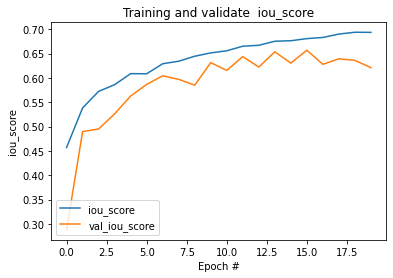

In [ ]:
#tab_compare=tab_compare.append(get_scoring(model_Final,'U-Net Final', val_generator,builf_Unet_time),ignore_index=True)
display_loss_and_metrics(20,history_f.history,["iou_score"])

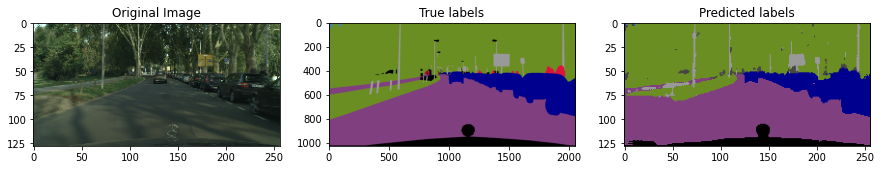

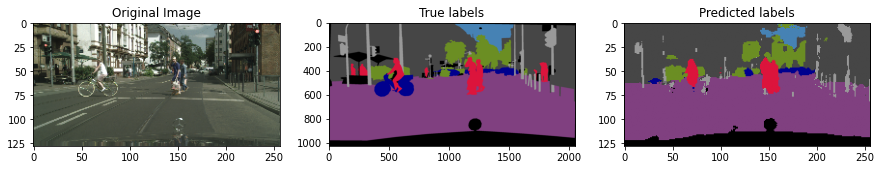

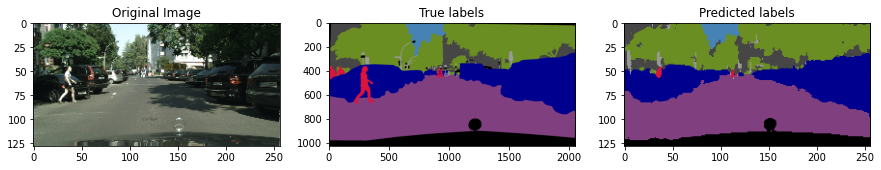

In [ ]:
display_random_test_images(model_Final,valid_set,colors_replacements,nb_images=3)

In [ ]:
model_Final.save('model_Final')

INFO:tensorflow:Assets written to: model_Final/assets
